## Engenharia de Sistemas de Software Inteligentes - Profs. Marcos Kalinowski e Tatiana Escovedo
## Predição de Parada Cardíaca

In [1]:
# configuração para não exibir os warnings
import warnings
warnings.filterwarnings("ignore")

# Imports necessários
import pickle as pickle
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.pipeline import Pipeline
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC

## Carga do Dataset

In [2]:
# Informa a URL de importação do dataset
url = "https://raw.githubusercontent.com/pquatro/puc_mvp3_datascience/main/heart_failure_clinical_records_dataset.csv"

# Lê o arquivo
dataset = pd.read_csv(url, delimiter=',')

# Mostra as primeiras linhas do dataset
dataset.head()

,age,anaemia,creatinine_phosphokinase,diabetes,ejection_fraction,high_blood_pressure,platelets,serum_creatinine,serum_sodium,sex,smoking,time,DEATH_EVENT
0,75.0,0,582,0,20,1,265000.00,1.9,130,1,0,4,1
1,55.0,0,7861,0,38,0,263358.03,1.1,136,1,0,6,1
2,65.0,0,146,0,20,0,162000.00,1.3,129,1,1,7,1
3,50.0,1,111,0,20,0,210000.00,1.9,137,1,0,7,1
4,65.0,1,160,1,20,0,327000.00,2.7,116,0,0,8,1


## Separação em conjunto de treino e conjunto de teste com holdout

In [6]:
test_size = 0.20 # tamanho do conjunto de teste
seed = 7 # semente aleatória

# Separação em conjuntos de treino e teste
array = dataset.values
X = array[:,0:12]
y = array[:,12]
X_train, X_test, y_train, y_test = train_test_split(X, y,
    test_size=test_size, shuffle=True, random_state=seed, stratify=y) # holdout com estratificação

# Parâmetros e partições da validação cruzada
scoring = 'accuracy'
num_particoes = 10
kfold = StratifiedKFold(n_splits=num_particoes, shuffle=True, random_state=seed) # validação cruzada com estratificação

#df = pd.DataFrame(X_test,y_test)
#df.to_csv('export_dataframe.csv', encoding='utf-8', index=False)
#df

## Modelagem e Inferência

### Criação e avaliação de modelos: linha base

KNN: 0.665217 (0.045850)
CART: 0.732428 (0.052430)
NB: 0.786051 (0.075721)
SVM: 0.677899 (0.017467)


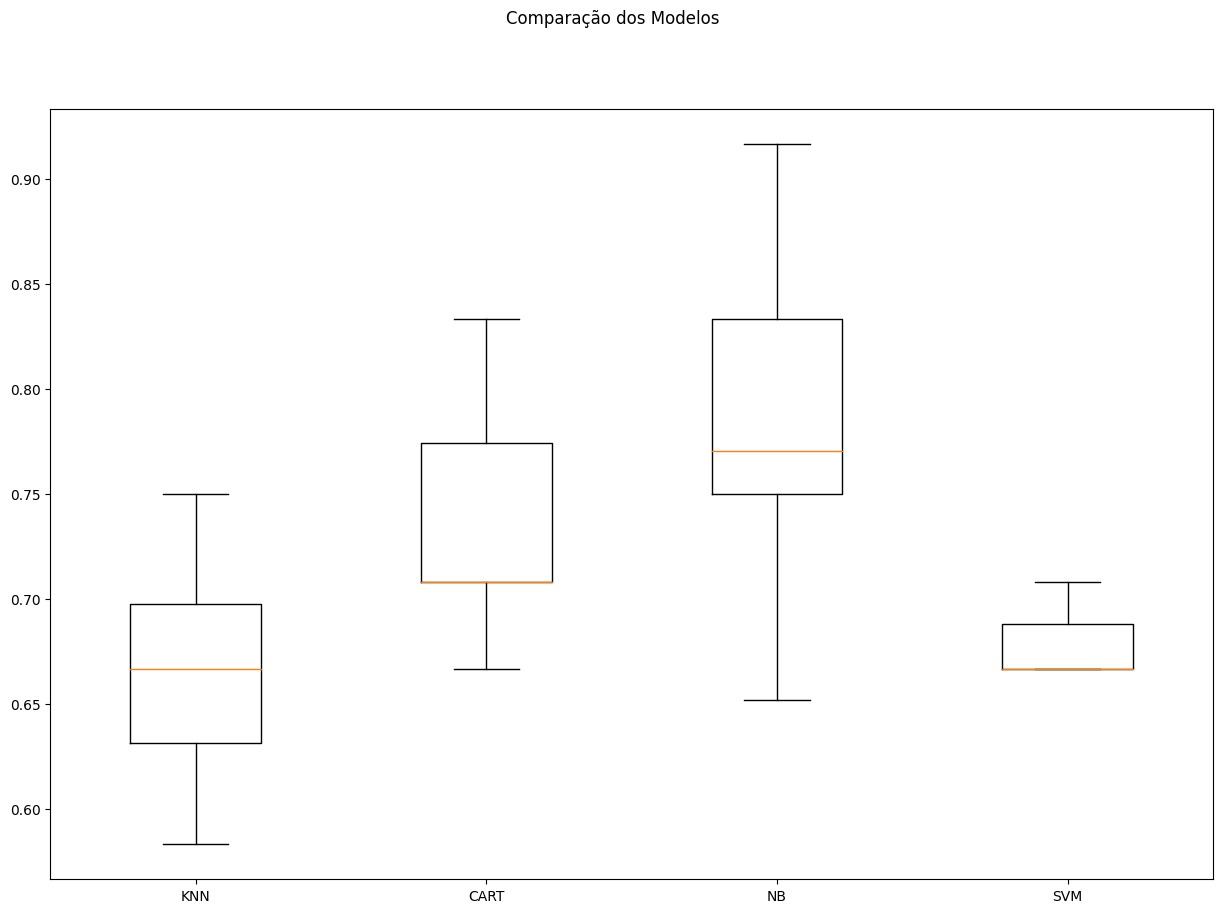

In [7]:
np.random.seed(7) # definindo uma semente global

# Lista que armazenará os modelos
models = []

# Criando os modelos e adicionando-os na lista de modelos
models.append(('KNN', KNeighborsClassifier()))
models.append(('CART', DecisionTreeClassifier()))
models.append(('NB', GaussianNB()))
models.append(('SVM', SVC()))

# Listas para armazenar os resultados
results = []
names = []


# Avaliação dos modelos
for name, model in models:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(15,10))
fig.suptitle('Comparação dos Modelos')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names)
plt.show()

### Criação e avaliação de modelos: dados padronizados e normalizados

KNN-orig: 0.665 (0.046)
CART-orig: 0.732 (0.052)
NB-orig: 0.786 (0.076)
SVM-orig: 0.678 (0.017)
KNN-padr: 0.770 (0.054)
CART-padr: 0.741 (0.052)
NB-padr: 0.761 (0.069)
SVM-padr: 0.803 (0.078)
KNN-norm: 0.703 (0.050)
CART-norm: 0.737 (0.041)
NB-norm: 0.761 (0.069)
SVM-norm: 0.787 (0.082)


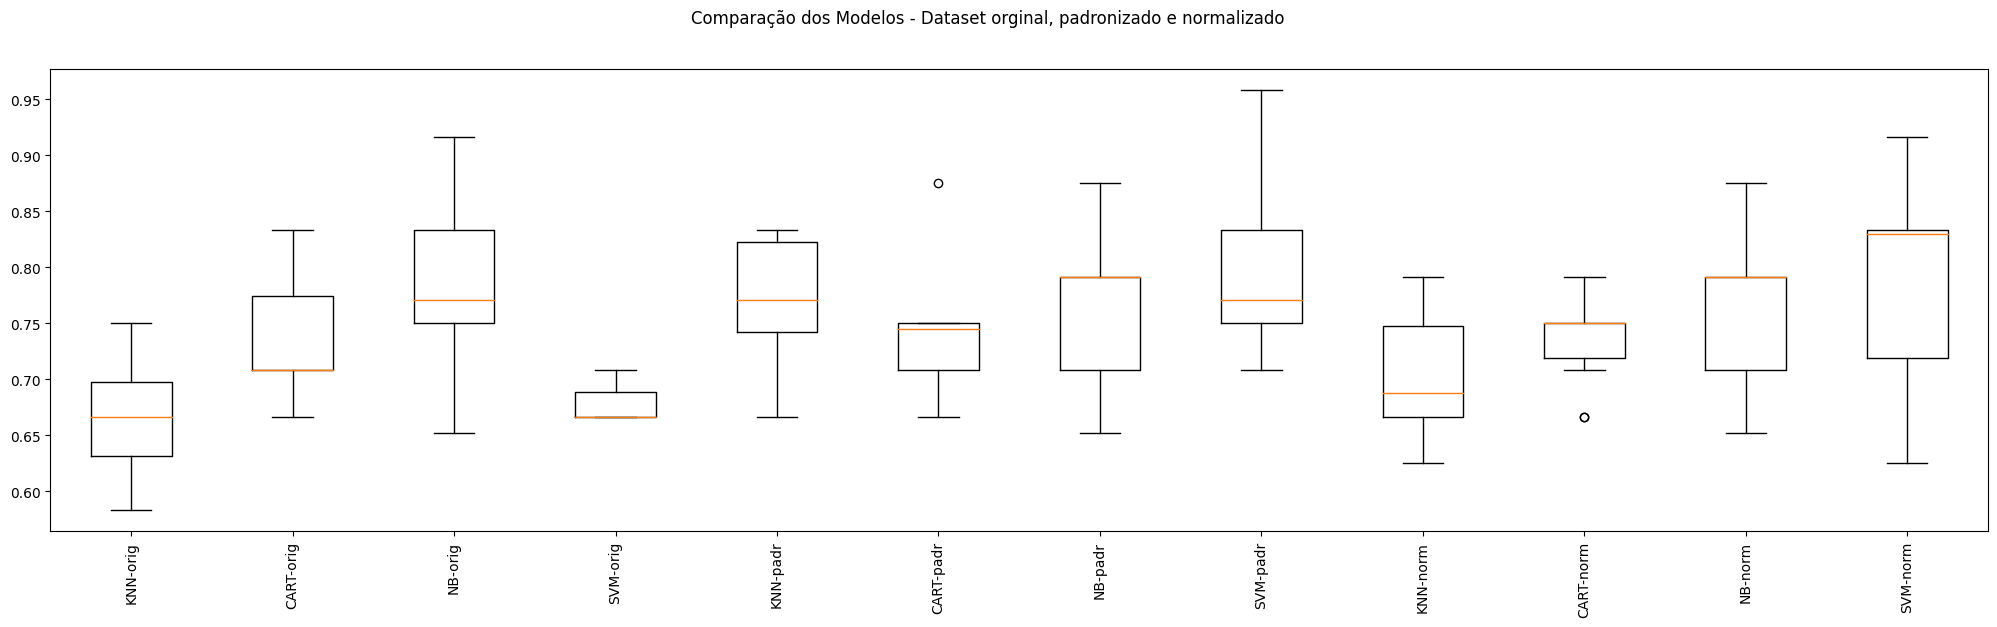

In [8]:
np.random.seed(7) # definindo uma semente global para este bloco

# Listas para armazenar os armazenar os pipelines e os resultados para todas as visões do dataset
pipelines = []
results = []
names = []


# Criando os elementos do pipeline

# Algoritmos que serão utilizados
knn = ('KNN', KNeighborsClassifier())
cart = ('CART', DecisionTreeClassifier())
naive_bayes = ('NB', GaussianNB())
svm = ('SVM', SVC())

# Transformações que serão utilizadas
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())


# Montando os pipelines

# Dataset original
pipelines.append(('KNN-orig', Pipeline([knn])))
pipelines.append(('CART-orig', Pipeline([cart])))
pipelines.append(('NB-orig', Pipeline([naive_bayes])))
pipelines.append(('SVM-orig', Pipeline([svm])))

# Dataset Padronizado
pipelines.append(('KNN-padr', Pipeline([standard_scaler, knn])))
pipelines.append(('CART-padr', Pipeline([standard_scaler, cart])))
pipelines.append(('NB-padr', Pipeline([standard_scaler, naive_bayes])))
pipelines.append(('SVM-padr', Pipeline([standard_scaler, svm])))

# Dataset Normalizado
pipelines.append(('KNN-norm', Pipeline([min_max_scaler, knn])))
pipelines.append(('CART-norm', Pipeline([min_max_scaler, cart])))
pipelines.append(('NB-norm', Pipeline([min_max_scaler, naive_bayes])))
pipelines.append(('SVM-norm', Pipeline([min_max_scaler, svm])))

# Executando os pipelines
for name, model in pipelines:
    cv_results = cross_val_score(model, X_train, y_train, cv=kfold, scoring=scoring)
    results.append(cv_results)
    names.append(name)
    msg = "%s: %.3f (%.3f)" % (name, cv_results.mean(), cv_results.std()) # formatando para 3 casas decimais
    print(msg)

# Boxplot de comparação dos modelos
fig = plt.figure(figsize=(25,6))
fig.suptitle('Comparação dos Modelos - Dataset orginal, padronizado e normalizado')
ax = fig.add_subplot(111)
plt.boxplot(results)
ax.set_xticklabels(names, rotation=90)
plt.show()

### Otimização dos hiperparâmetros

In [9]:
# Tuning do KNN

np.random.seed(7) # definindo uma semente global para este bloco

pipelines = []

# Definindo os componentes do pipeline
knn = ('KNN', KNeighborsClassifier())
standard_scaler = ('StandardScaler', StandardScaler())
min_max_scaler = ('MinMaxScaler', MinMaxScaler())

pipelines.append(('knn-orig', Pipeline(steps=[knn])))
pipelines.append(('knn-padr', Pipeline(steps=[standard_scaler, knn])))
pipelines.append(('knn-norm', Pipeline(steps=[min_max_scaler, knn])))

param_grid = {
    'KNN__n_neighbors': [1,3,5,7,9,11,13,15,17,19,21],
    'KNN__metric': ["euclidean", "manhattan", "minkowski"],
}

# Prepara e executa o GridSearchCV
for name, model in pipelines:
    grid = GridSearchCV(estimator=model, param_grid=param_grid, scoring=scoring, cv=kfold)
    grid.fit(X_train, y_train)
    # imprime a melhor configuração
    print("Melhor modelo: %s - Melhor: %f usando %s" % (name, grid.best_score_, grid.best_params_))

Melhor modelo: knn-orig - Melhor: 0.673551 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 5}
Melhor modelo: knn-padr - Melhor: 0.769746 usando {'KNN__metric': 'euclidean', 'KNN__n_neighbors': 5}
Melhor modelo: knn-norm - Melhor: 0.761594 usando {'KNN__metric': 'manhattan', 'KNN__n_neighbors': 11}


## Finalização do Modelo

In [15]:
# Avaliação do modelo com o conjunto de testes

# Preparação do modelo
scaler = StandardScaler().fit(X_train) # ajuste do scaler com o conjunto de treino
rescaledX = scaler.transform(X_train) # aplicação da padronização no conjunto de treino
model = KNeighborsClassifier(metric='euclidean', n_neighbors=5)
model.fit(rescaledX, y_train)

# Estimativa da acurácia no conjunto de teste
rescaledTestX = scaler.transform(X_test) # aplicação da padronização no conjunto de teste
predictions = model.predict(rescaledTestX)
print(accuracy_score(y_test, predictions))



0.7333333333333333


In [16]:
# Preparação do modelo com TODO o dataset
scaler = StandardScaler().fit(X) # ajuste do scaler com TODO o dataset
rescaledX = scaler.transform(X) # aplicação da padronização com TODO o dataset
model.fit(rescaledX, y)

KNeighborsClassifier(metric='euclidean')

## Simulando a aplicação do modelo em dados não vistos

In [41]:
# Novos dados - não sabemos a classe!
data = {'age':  [18, 30, 80],
        'anae': [0, 0, 0],
        'crea': [150, 150, 50],
        'diab': [1, 0, 1],
        'ejec': [40, 40, 15],
        'high': [0, 0, 0],
        'plate': [270000,270000,155000],
        'ser_crea': [1.0, 2.0, 3.0],
        'ser_sodi': [140,140,110],
        'sex': [1,0,1],
        'smok': [0,0,0],
        'tim': [2,0,4],
        }




atributos = ['age', 'anae', 'crea', 'diab', 'ejec', 'high', 'plate', 'ser_crea', 'ser_sodi', 'sex', 'smok', 'tim']
entrada = pd.DataFrame(data, columns=atributos)

array_entrada = entrada.values
X_entrada = array_entrada[:,0:12].astype(float)

# Padronização nos dados de entrada usando o scaler utilizado em X
rescaledEntradaX = scaler.transform(X_entrada)
print(rescaledEntradaX)

[[-3.60709461 -0.87110478 -0.44580936  1.1798305   0.16219911 -0.73568819
   0.06802472 -0.38137852  0.76606383  0.73568819 -0.68768191 -1.65531409]
 [-2.59655991 -0.87110478 -0.44580936 -0.84757938  0.16219911 -0.73568819
   0.06802472  0.58688315  0.76606383 -1.35927151 -0.68768191 -1.68112577]
 [ 1.61400136 -0.87110478 -0.54904434  1.1798305  -1.95374919 -0.73568819
  -1.10976466  1.55514483 -6.04423603  0.73568819 -0.68768191 -1.62950241]]


In [42]:
# Predição de classes dos dados de entrada
saidas = model.predict(rescaledEntradaX)
print(saidas)

[0. 0. 1.]


## Gerando o arquivo PKL

In [20]:
pickle_out = open("modelo_treinado.pkl","wb")
pickle.dump(model,pickle_out)
pickle_out.close()